## PSF Photometry

To proceed with this guide, both Synphot and WebbPSF must be properly installed.  Follow the instructions at https://webbpsf.readthedocs.io/en/latest/installation.html to install WebbPSF and the required data files, and use https://synphot.readthedocs.io/en/latest/ to do the same for Synphot.  Remember to set the necessary environment variables.

In [1]:
# Execute this cell block to download WebbPSF and Synphot data

!pip install --upgrade webbpsf # remove '--upgrade' if you have not installed WebbPSF before
!pip install synphot

import jwst
import webbpsf
import synphot
import os
import tarfile
from urllib import request

# Set environment variables
os.environ['WEBBPSF_PATH']  = './webbpsf-data/webbpsf-data'
os.environ['PYSYN_CDBS'] = './grp/redcat/trds/'

# WebbPSF, Synphot Data - current releases as of July 2024
webbpsf_link = 'https://stsci.box.com/shared/static/qxpiaxsjwo15ml6m4pkhtk36c9jgj70k.gz'
webbpsf_file = './webbpsf-data/webbpsf-data-LATEST.tar.gz'
# because of the size of the synphot data files, they are separated into different tar files
# we download the 'Phoenix' models
synphot_url = 'http://ssb.stsci.edu/trds/tarfiles/synphot5.tar.gz'
synphot_file = './synphot5.tar.gz'
# can also be found in the STSci reference atlas (https://archive.stsci.edu/hlsp/reference-atlases) as 'synphot5_pheonix-models.tar'
# some users report that synphot does not untar correctly.  if this occurs, please download from the provided link and then untar
# into the appropriate folder
# because we pick and choose what to download, we will expect a handful of 'WARNING: Failed to load [] spectrum' messages that we can ignore

webbpsf_folder = './webbpsf-data'
synphot_folder = './grp'

# Gather WebbPSF files
if not os.path.exists(webbpsf_folder): # if there's no 'webbpsf_folder'...
    os.makedirs(webbpsf_folder) # we create such a folder
    request.urlretrieve(webbpsf_link, webbpsf_file) # download the specified file from the link
    gzf = tarfile.open(webbpsf_file) # open the downloaded tar file
    gzf.extractall(webbpsf_folder) # and extract its contents to the folder
# Gather Synphot files
if not os.path.exists(synphot_folder): # if there's no 'synphot_folder'...
    os.makedirs(synphot_folder) # we create such a folder
    request.urlretreive(synphot_link, synphot_file) # download the specified file from the link
    gzf = tarfile.open(synphot_file) # open the downloaded tar file
    gzf.extractall('./') # and extract its contents to the folder
    
# in all likelihood, this cell will take a long time to run if you do not already have the webbpsf or synphot data

ERROR: Invalid requirement: '#'


In [2]:
# To begin, we load in the images, then create a 'dictionary' that contains all of them, separated by detectors and filters.
# NIRCam has ten detectors over two modules.  We refer to the 'LONG' detector names as '5' instead to follow the numerical convention
# as well as simplify future commands.

import glob
from astropy.io import fits
# Our first dictionary will contain the single Level-2 calibrated images
dict_images = {'NRCA1': {}, 'NRCA2': {}, 'NRCA3': {}, 'NRCA4': {}, 'NRCA5': {}, 'NRCB1': {}, 'NRCB2': {}, 'NRCB3': {}, 'NRCB4': {}, 'NRCB5': {}}
# then our directionaries contain the long and short filters
dict_filter_short = {}
dict_filter_long = {}
# We create a series of empty arrays that we can add to in order to eventually contribute to our dictionary
ff_short = []
ff_long = []
det_short = []
det_long = []
detlist_short = []
detlist_long = []
filtlist_short = []
filtlist_long = []

if not glob.glob('./*cal*fits'):
 # if we need to download the data (there are no 'cal' files in the current directory)
    print('Downloading images...')
    link_images_lev2 = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/stellar_photometry/images_level2.tar.gz'
    file_images_lev2 = './images_level2.tar.gz'
    request.urlretrieve(link_images_lev2, file_images_lev2)
    tar = tarfile.open(file_images_lev2, 'r')
    tar.extractall()
    
    images_dir = './'
    images = sorted(glob.glob(os.path.join(images_dir, "*cal.fits"))) # gather the image files
else:
# if you already have them downloaded, the images are the '_cal.fits' files in your folder
    images_dir = './'
    images = sorted(glob.glob(os.path.join(images_dir,'*cal.fits'))) # gather the image files

for image in images: # iterate through the images
    im = fits.open(image) # open the .fits image file
    f = im[0].header['FILTER'] # from the header, grab the filter info
    d = im[0].header['DETECTOR'] # from the header, grab the detector info

    # as mentioned before, we rename 'LONG' to '5'
    if d == 'NRCBLONG': 
        d = 'NRCB5'
    elif d == 'NRCALONG':
        d = 'NRCA5'
    else:
        d = d

    wv = float(f[1:3]) # just grab the hundredth and tenth place of the filter name (i.e. wv = 27 for filter F277W)
    # to separate out short wavelength (0.6-2.3 micrometers) filters from long wavelength (2.4-5.0 mircometers) filters
    if wv > 24: # for long wavelength filters
        ff_long.append(f) # add image to our list of long filters
        det_long.append(d) # add image to our list of long detectors
    else:
        ff_short.append(f)
        det_short.append(d) 
        
    detlist_short = sorted(list(dict.fromkeys(det_short))) # make a sorted list of the short wavelength detectors
    detlist_long = sorted(list(dict.fromkeys(det_long))) # make a sorted list of the long wavelength detectors

    unique_list_filters_short = []
    unique_list_filters_long = []
    # we will also identify what the unique filter options are for the short- and long-wavelength channels

    for x in ff_short: # for every filter that we've identified as 'short'
        if x not in unique_list_filters_short: # if it's not in the unique filters list,
            dict_filter_short.setdefault(x, {}) # add it
    for x in ff_long: # for every filter that we've identified as 'long'
        if x not in unique_list_filters_long: # if it's not in the unique filters list,
            dict_filter_long.setdefault(x, {}) # add it

    for d_s in detlist_short: # from our sorted list of short detectors,
        dict_images[d_s] = dict_filter_short # add the _cal.fits files that correspond to it to the image dictionary
    for d_l in detlist_long: # from our sorted list of long detectors,
        dict_images[d_l] = dict_filter_long # add the _cal.fits files that correspond to it to the image dictionary

    filtlist_short = sorted(list(dict.fromkeys(dict_filter_short))) # sorted list of short wavelength filters
    filtlist_long = sorted(list(dict.fromkeys(dict_filter_long))) # sorted list of long wavelength filters
    
    if len(dict_images[d][f]) == 0: # if we don't have a detector-filter pair in our dictionary
        dict_images[d][f] = {'images': [image]} # add the image that corresponds to it
    else: # if there already exists such a pair
        dict_images[d][f]['images'].append(image) # append the image to the image list for that pairing

# finally, we print our available detectors and filters
print("Available Detectors for SW channel:", detlist_short)
print("Available Detectors for LW channel:", detlist_long)
print("Available SW Filters:", filtlist_short)
print("Available LW Filters:", filtlist_long)

Available Detectors for SW channel: ['NRCB1']
Available Detectors for LW channel: ['NRCB5']
Available SW Filters: ['F070W', 'F115W', 'F200W']
Available LW Filters: ['F277W', 'F356W', 'F444W']


In [3]:
# The dictionary additionlly contains the NIRCam point spread function (PSF) full-width half-maximum (FWHM) values from
# https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-performance/nircam-point-spread-functions
# the list of possible filters is:
filters = ['F070W', 'F090W', 'F115W', 'F140M', 'F150W2', 'F150W', 'F162M', 'F164N', 'F182M','F187N', 'F200W', 'F210M', 'F212N', 'F250M', 'F277W', 'F300M', 
           'F322W2', 'F323N','F335M', 'F356W', 'F360M', 'F405N', 'F410M', 'F430M', 'F444W', 'F460M', 'F466N', 'F470N', 'F480M']
# with correspond FWHMs:
psf_fwhm = [0.987, 1.103, 1.298, 1.553, 1.628, 1.770, 1.801, 1.494, 1.990, 2.060, 2.141, 2.304, 2.341, 1.340, 1.444, 1.585, 1.547, 1.711, 1.760, 1.830, 
            1.901, 2.165, 2.179, 2.300, 2.302, 2.459, 2.507, 2.535, 2.574]
# finally, we create our utility dictionary
# for each filter, match the PSF FWHM for both modules
dict_utils = {filters[i]: {'psf fwhm': psf_fwhm[i]} for i in range(len(filters))}

In [4]:
# In this example, we first choose to analyze the filters F115W and F200W for detector NRCA1;
# because it is in the SW channel, we use our '_short' lists
dets_short = ['NRCB1'] # set the detector of interest
filts_short = ['F115W', 'F200W'] # set the filters of interest

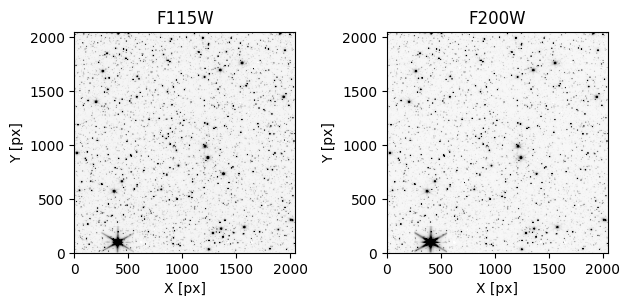

In [5]:
# We must visually verify that the images do not contain artifacts and therefore can be used in our analysis
# This code block is written generally so that any number of selected detectors and filters can be passed in
from matplotlib import pyplot as plt
plt.rcParams['image.origin'] = 'lower'
from astropy.visualization import simple_norm
for det in dets_short: # for selected detector
     for i, filt in enumerate(filts_short): # for the selected filters
        image = fits.open(dict_images[det][filt]['images'][0]) # open the corresponding image
        data_sb = image[1].data # the data we're plotting
        ax = plt.subplot(1, len(filts_short), i + 1) # define our subplot with the appropriate numerical location     
        # figure has 1 row, 2 col (since 2 filters in filts_short), and 'i+1' separates the first plot (the first iteration of the inside for loop) 
        # and the second plot (the second iteration of the inside for loop)
        plt.xlabel("X [px]") # label the x-axis
        plt.ylabel("Y [px]") # label the y-axis
        plt.title(filt) # create the title
        norm = simple_norm(data_sb, 'sqrt', percent=99.) # astropy function to normalize the images, applies a square root stretch function
        ax.imshow(data_sb, norm=norm, cmap='Greys') # show the data with the specified normalization, 
        # with an origin point at the lower righthand side, and a grayscale color map
plt.tight_layout()

In [6]:
# Using WebbPSF, we will now create the PSF model
# We start by creating a dictionary that will contain the PSF that WebbPSF creates, for the detector and filter we previously selected.
dict_psfs_webbpsf = {} # our new dictionary
for det in dets_short: # for our selected detectors
    dict_psfs_webbpsf.setdefault(det, {}) # essentially, make new dictionary the same dimensions as the detectors of interest list
    for j, filt in enumerate(filts_short): # for each filter,
        dict_psfs_webbpsf[det].setdefault(filt, {})   # same thing as above (but with the filters of interest)
        dict_psfs_webbpsf[det][filt]['psf model grid'] = None # we create the category of 'grid' PSFs
        dict_psfs_webbpsf[det][filt]['psf model single'] = None # and the category of 'single' PSFs

In [7]:
# We define a function that allows us to choose if we want to create a single PSF or a grid of PSFs, 
# and additionally if we want to save the PSF as a .fits file.  By default, we store the model PSF in our PSF dictionary
# Because we have installed synphot, the default source spectrum is a G2V star spectrum from Castelli & Kurucz (2004);
# if we had not done this, the default would have been a simple flat spectrum where each wavelength has the same number of detected photons
# the passed-in parameters of the function are the following:
# fov: size in pixels of PSF model
# create_grid: create single or grid of PSFs
# num: total number of fiducial PSFs to be created and saved (must be a square number)
# save_psf: save PSF as fits file
# detsampled: detected sampled or oversampled
def create_psf_model(fov=11,create_grid=False,num=9,save_psf=False,detsampled=False): # create function, specify default parameter values
    nrc = webbpsf.NIRCam() # create a NIRCam instance
    nrc.detector = det 
    nrc.filter = filt
    
    src = webbpsf.specFromSpectralType('G0V', catalog='phoenix') # define the source spectrum object from pysynphot CDBS directory (from the phoenix models)

    if detsampled: #  if detsampled true - creates a detector sampled PSF, if false (default)- creates an oversampled PSF
        print("Creating a detector sampled PSF")
        fov = 21
    else:
        print("Creating an oversampled PSF")
        fov = fov
    print(f"Using a {fov} px fov")

    if create_grid: # if true, will output psf grid
        print("")
        print(f"Creating a grid of PSF for filter {filt} and detector {det}")
        print("")
        num = num # number of psfs to create

        if save_psf: # if true, save PSF to .fits file
            outname = f"./PSF_{filt}_samp4_G0V_fov{fov}_npsfs{num}.fits" # name of saved file
            nrc.psf_grid(num_psfs=num, oversample=4, source=src, all_detectors=False, fov_pixels=fov,
                         save=True, outfile=outname, use_detsampled_psf=detsampled) # run command to create PSF grid
        else:
            grid_psf = nrc.psf_grid(num_psfs=num, oversample=4, source=src, all_detectors=False,
                                    fov_pixels=fov, use_detsampled_psf=detsampled) # run command to create PSF grid
            dict_psfs_webbpsf[det][filt]['psf model grid'] = grid_psf # save PSF grid to dictionary
    else:
        print("")
        print(f"Creating a single PSF for filter {filt} and detector {det}")
        print("")
        num = 1

        if save_psf:
            outname = f"./PSF_{filt}_samp4_G0V_fov{fov}_npsfs{num}.fits" # name of saved file
            nrc.psf_grid(num_psfs=num, oversample=4, source=src, all_detectors=False, fov_pixels=fov,
                         save=True, outfile=outname, use_detsampled_psf=detsampled) # run command to create single PSF
        else:
            single_psf = nrc.psf_grid(num_psfs=num, oversample=4, source=src, all_detectors=False,
                                      fov_pixels=fov, use_detsampled_psf=detsampled) # run command to create single PSF
            dict_psfs_webbpsf[det][filt]['psf model single'] = single_psf # save single PSF to dictionary

    return  

In [8]:
for det in dets_short: # for selected detector(s)
    for filt in filts_short: # for selected filter(s)
        create_psf_model(fov=11, num=1, create_grid=False, save_psf=False, detsampled=False) # create single PSF

Creating an oversampled PSF
Using a 11 px fov

Creating a single PSF for filter F115W and detector NRCB1


Running instrument: NIRCam, filter: F115W
  Running detector: NRCB1
    Position 1/1: (1023, 1023) pixels
    Position 1/1 centroid: (21.609885093325573, 21.35077177726363)
Creating an oversampled PSF
Using a 11 px fov

Creating a single PSF for filter F200W and detector NRCB1


Running instrument: NIRCam, filter: F200W
  Running detector: NRCB1
    Position 1/1: (1023, 1023) pixels
    Position 1/1 centroid: (21.636711308247452, 21.31018801313345)


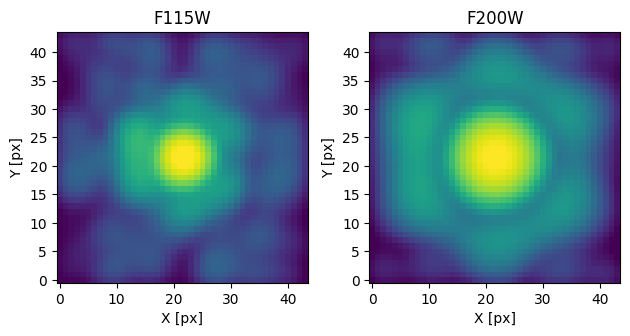

In [9]:
for det in dets_short: # for selected detector(s)
    for i, filt in enumerate(filts_short): # for selected filters(s)
        ax = plt.subplot(1, 2, i + 1) # define subplots
        norm_epsf = simple_norm(dict_psfs_webbpsf[det][filt]['psf model single'].data[0], 'log', percent=99.) 
            # astropy function to normalize the images, applies a square root stretch function
        ax.set_title(filt) # specify title
        ax.set_xlabel('X [px]') # specify x-axis label
        ax.set_ylabel('Y [px]') # specify y-axis label
        ax.imshow(dict_psfs_webbpsf[det][filt]['psf model single'].data[0], norm=norm_epsf) # display selected PSF(s)
plt.tight_layout()

In [10]:
for det in dets_short: # for selected detector(s)
    for filt in filts_short: # for selected filter(s)
        create_psf_model(fov=11, num=9, create_grid=True, save_psf=False, detsampled=False) # create 3x3 PSF grid

Creating an oversampled PSF
Using a 11 px fov

Creating a grid of PSF for filter F115W and detector NRCB1


Running instrument: NIRCam, filter: F115W
  Running detector: NRCB1
    Position 1/9: (0, 0) pixels
    Position 1/9 centroid: (21.414131613060754, 21.278205411333772)
    Position 2/9: (0, 1024) pixels
    Position 2/9 centroid: (21.5888491903819, 21.130534708815663)
    Position 3/9: (0, 2047) pixels
    Position 3/9 centroid: (21.803264172967296, 21.236951815669347)
    Position 4/9: (1024, 0) pixels
    Position 4/9 centroid: (21.42891441708216, 21.31840615420171)
    Position 5/9: (1024, 1024) pixels
    Position 5/9 centroid: (21.610020941414323, 21.350922937852364)
    Position 6/9: (1024, 2047) pixels
    Position 6/9 centroid: (21.865621646047238, 21.352655447121197)
    Position 7/9: (2047, 0) pixels
    Position 7/9 centroid: (21.457069245370505, 21.69698564395663)
    Position 8/9: (2047, 1024) pixels
    Position 8/9 centroid: (21.589514134223734, 21.584007974085175)

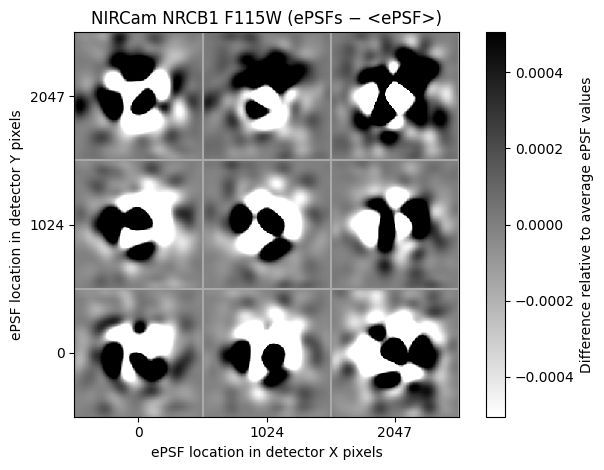

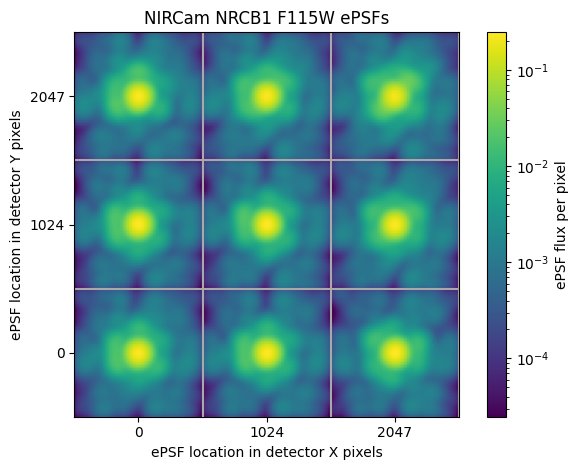

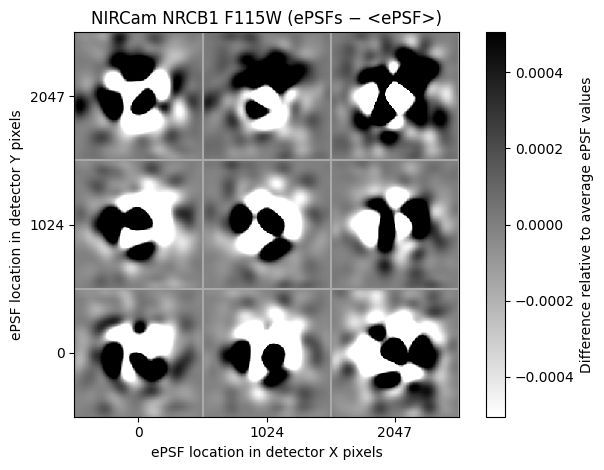

In [11]:
dict_psfs_webbpsf[dets_short[0]][filts_short[0]]['psf model grid'].plot_grid() # display PSF grid
dict_psfs_webbpsf[dets_short[0]][filts_short[0]]['psf model grid'].plot_grid(deltas=True) # display differences from mean PSF

In [12]:
# We proceed to building the effective PSFs (ePSFs)
# First, we create a dictionary that contains the effective PSF for the selected detectors and filters
import numpy as np
dict_psfs_epsf = {} # initialize empty dictionary for ePSFs
for det in dets_short: # for selected detector(s)
    dict_psfs_epsf.setdefault(det, {}) # make ePSF dictionary with the same dimension as the the short wavelength detectors list
    for j, filt in enumerate(filts_short): # for selected filter(s)
        dict_psfs_epsf[det].setdefault(filt, {}) # make ePSF dictionary the same dimension as the short wavelength filters list
        dict_psfs_epsf[det][filt]['table psf stars'] = {} # create the category of selected stars 
        dict_psfs_epsf[det][filt]['epsf single'] = {} # create the category of single ePSF
        dict_psfs_epsf[det][filt]['epsf grid'] = {} # create the category of ePSF grid
        for i in np.arange(0, len(dict_images[det][filt]['images']), 1): # for each selected image
            dict_psfs_epsf[det][filt]['table psf stars'][i + 1] = None # populate with 'None'
            dict_psfs_epsf[det][filt]['epsf single'][i + 1] = None # populate with 'None'
            dict_psfs_epsf[det][filt]['epsf grid'][i + 1] = None # populate with 'None'

In [13]:
# Now, we select the stars from which we will build the PSF
from photutils.background import MADStdBackgroundRMS, MMMBackground
from photutils.detection import DAOStarFinder
def find_stars_epsf(img_num, filt_num, det='NRCA1', filt='F070W', dist_sel=False, var_bkg=False):
    bkgrms = MADStdBackgroundRMS() # class to calculate the background RMS in an array as using the median absolute deviation (MAD)
    mmm_bkg = MMMBackground() # class to calculate the background in an array using the DAOPHOT MMM algorithm

    image = fits.open(dict_images[det][filt]['images'][img_num]) # open the image
    data_sb = image[1].data # the data we're using
    imh = image[1].header # image header
    
    print(f"Finding PSF stars on image {img_num + 1} of filter {filt}, detector {det}")

    data = data_sb / imh['PHOTMJSR'] # convert from actual unit of image ('BUNIT'), then from MJy/sr to DN/s (1/PHOTMJSR)
    units = imh['BUNIT']
    print(f"Conversion factor from {units} to DN/s for filter {filt}: {imh['PHOTMJSR']}")

    sigma_psf = dict_utils[filt]['psf fwhm'] # FWHM of the PSF

    print(f"FWHM for the filter {filt}: {sigma_psf} px")

    if var_bkg: # if the background has been labeled as variable
        print("Using 2D Background")
        sigma_clip = SigmaClip(sigma=3.) # remove elements outside of 3*FHWM
        coverage_mask = (data == 0) # boolean mask of zero-value data 

        bkg = Background2D(data, (25, 25), filter_size=(3, 3), sigma_clip=sigma_clip, bkg_estimator=mmm_bkg,
                           coverage_mask=coverage_mask, fill_value=0.0) # use Background2D class to estimate background
            # (25,25) is the box size along each axis; the filter size is the window size of the 2D median filter to apply to the low-resolution background map
            # the fill value is the value used to fill the output background and background RMS maps where the input coverage_mask is True

        data_bkgsub = data.copy # make a copy of the data
        data_bkgsub = data_bkgsub - bkg.background # # subtract the background from the data

        _, _, std = sigma_clipped_stats(data_bkgsub) # for the background-subtracted data, find the mean, median, and standard deviation using sigma-clipped statistics
    else: # for a non-variable background
        std = bkgrms(data) # background RMS of the data
        bkg = mmm_bkg(data) # background of the data
        data_bkgsub = data.copy() # copy the data
        data_bkgsub -= bkg # subtract the background from the data
        
    daofind = DAOStarFinder(threshold=th[filt_num] * std + bkg, fwhm=sigma_psf, roundhi=1.0, roundlo=-1.0,
                            sharplo=0.30, sharphi=1.40) # DAOStarFinder detects stars using the DAOFIND algorithm
        # the threshold is the absolute image value above which to select sources, where
        # th[filt_num] is the threshold level for each filter, represented by the integer values of filt_num
        # roundhi is the upper bound on 'roundness' for object detection; roundlo is the lower bound
        # sharplo is the lower bound on 'sharpness' for object detection; sharphi is the upper bound
    psf_stars = daofind(data) # detect stars in the data
    dict_psfs_epsf[det][filt]['table psf stars'][img_num + 1] = psf_stars # add to our dictionary the found stars

    if dist_sel: # if we choose to calculate a minimum separation distance needed for choosing stars for the sample
        print("")
        print("Calculating closest neigbhour distance")
        d = [] # distances list

        daofind_tot = DAOStarFinder(threshold=10 * std + bkg, fwhm=sigma_psf, roundhi=1.0, roundlo=-1.0,
                                    sharplo=0.30, sharphi=1.40) # much lower threshold than the previous daofind run
        stars_tot = daofind_tot(data) # detect stars in the data

        x_tot = stars_tot['xcentroid'] # x-centroids of selected/detected stars
        y_tot = stars_tot['ycentroid'] # y-centroids of selected/detected stars

        for xx, yy in zip(psf_stars['xcentroid'], psf_stars['ycentroid']): # zip() groups together the xcentroid and ycentroid from psf_stars together into a list of tuples
            # to find separation between bright stars (psf_stars) and others (stars_tot) (distinguished by their threshold values)
            sep = [] # separations
            dist = np.sqrt((x_tot - xx)**2 + (y_tot - yy)**2) # distance formula
            sep = np.sort(dist)[1:2][0] # sort separations, and take first non-zero value
            d.append(sep) # add the separations to the distances list

        psf_stars['min distance'] = d # add minimum distance info to the psf_stars variable as a new keyword
        mask_dist = (psf_stars['min distance'] > min_sep[filt_num]) # create mask that
        # returns which indices in psf_stars['min distance'] is greater than the minimum required separation (as provided by the user)

        psf_stars = psf_stars[mask_dist] # uses indices of mask_dist to adjust psf_stars to only those that fall outside the required distance

        dict_psfs_epsf[det][filt]['table psf stars'][img_num + 1] = psf_stars   #add new psf_stars info to table

        print("Minimum distance required:", min_sep[filt_num], "px")
        print("")
        print(f"Number of isolated sources found in the image used to build ePSF for {filt}: {len(psf_stars)}")
        print("-----------------------------------------------------")
        print("")
    else:
        print("")
        print(f"Number of sources used to build ePSF for {filt}: {len(psf_stars)}")
        print("--------------------------------------------")
        print("")

In [14]:
import time
tic = time.perf_counter() # start performance counter that returns float value of time in seconds
th = [700, 500]  # threshold level for the two filters (length must match number of filters analyzed)
min_sep = [10, 10]  # minimum separation acceptable for ePSF stars from closest neighbour

for det in dets_short: # for the selected detector(s)
    for j, filt in enumerate(filts_short): # for the selected filter(s)
        for i in np.arange(0, len(dict_images[det][filt]['images']), 1): # for each image 
            find_stars_epsf(i, j, det=det, filt=filt, dist_sel=False) # find ePSF stars 
toc = time.perf_counter() # stop counter
print("Elapsed Time for finding stars:", toc - tic) # elapsed time

Finding PSF stars on image 1 of filter F115W, detector NRCB1
Conversion factor from MJy/sr to DN/s for filter F115W: 3.821892261505127
FWHM for the filter F115W: 1.298 px

Number of sources used to build ePSF for F115W: 1306
--------------------------------------------

Finding PSF stars on image 2 of filter F115W, detector NRCB1
Conversion factor from MJy/sr to DN/s for filter F115W: 3.821892261505127
FWHM for the filter F115W: 1.298 px

Number of sources used to build ePSF for F115W: 1324
--------------------------------------------

Finding PSF stars on image 3 of filter F115W, detector NRCB1
Conversion factor from MJy/sr to DN/s for filter F115W: 3.821892261505127
FWHM for the filter F115W: 1.298 px

Number of sources used to build ePSF for F115W: 1307
--------------------------------------------

Finding PSF stars on image 4 of filter F115W, detector NRCB1
Conversion factor from MJy/sr to DN/s for filter F115W: 3.821892261505127
FWHM for the filter F115W: 1.298 px

Number of sourc

In [15]:
# Once we have our stars, we can define a function to build our ePSFs
from astropy.table import Table
from astropy.nddata import NDData
from photutils.psf import extract_stars
from photutils.psf import EPSFBuilder
def build_epsf(det='NRCA1', filt='F070W'): # create function, passing in default values for our two parameters
    mmm_bkg = MMMBackground() # class to calculate the background in an array using the DAOPHOT MMM algorithm
    
    image = fits.open(dict_images[det][filt]['images'][i]) # open the image
    data_sb = image[1].data # the data we're using
    imh = image[1].header # image header

    data = data_sb / imh['PHOTMJSR'] # unit conversion as before

    hsize = (sizes[j] - 1) / 2 # filter size that's midpoint of cutout for each psf star, based on 'sizes' defined outside of function in next cell
    x = dict_psfs_epsf[det][filt]['table psf stars'][i + 1]['xcentroid'] # x-centroid
    y = dict_psfs_epsf[det][filt]['table psf stars'][i + 1]['ycentroid'] # y-centroid
    mask = ((x > hsize) & (x < (data.shape[1] - 1 - hsize)) & (y > hsize) & (y < (data.shape[0] - 1 - hsize)))
    # create a mask using the hsize and data shape

    stars_tbl = Table() # create table of stars
    stars_tbl['x'] = x[mask] # with x-values within the mask
    stars_tbl['y'] = y[mask] # and y-values within the mask

    bkg = mmm_bkg(data) # background of the data
    data_bkgsub = data.copy() # copy the data
    data_bkgsub -= bkg # subtract the background from the data

    nddata = NDData(data=data_bkgsub) # NDData class takes the input dataset and puts it in a container, which is needed because...
    stars = extract_stars(nddata, stars_tbl, size=sizes[j]) # extract_stars only accepts NDData objects
    # using the container of our background-subtracted data, the star table, and the size of the cutout,
    # extract cutout images centered on stars defined in the input catalog/table

    print(f"Creating ePSF for image {i + 1} of filter {filt}, detector {det}")

    epsf_builder = EPSFBuilder(oversampling=oversample, maxiters=3, progress_bar=False) # build the ePSF
    # oversample is the integer oversampling factor of the ePSF, and is defined in the next cell;
    # maxiters is the maximum number of iterations to perform, usually 10+ but here lowered to limit runtime
    # progress_bar requires installation of tqdm
    
    epsf, fitted_stars = epsf_builder(stars) # run our stars through our new ePSF builder, 
    # returning the constructed ePSF and the input stars with updated centers and fluxes (derived from fitting the output ePSF)
    dict_psfs_epsf[det][filt]['epsf single'][i + 1] = epsf # add our new ePSF to our dictionary

In [16]:
tic = time.perf_counter() # create and start timer

sizes = [11, 11]  # size of the cutout (extract region) for each PSF star - must match number of filters analyzed (must be odd valued)
oversample = 4 # integer oversampling factor of the ePSF, 4 is the default

for det in dets_short: # for selected detector(s)
    for j, filt in enumerate(filts_short): # for selected filter(s)
        for i in np.arange(0, len(dict_images[det][filt]['images']), 1): # for each image
            build_epsf(det=det, filt=filt) # create an ePSF

toc = time.perf_counter() # end timer

print("Time to build the Effective PSF:", toc - tic)

Creating ePSF for image 1 of filter F115W, detector NRCB1
Creating ePSF for image 2 of filter F115W, detector NRCB1


Creating ePSF for image 3 of filter F115W, detector NRCB1
Creating ePSF for image 4 of filter F115W, detector NRCB1
Creating ePSF for image 1 of filter F200W, detector NRCB1


Creating ePSF for image 2 of filter F200W, detector NRCB1


Creating ePSF for image 3 of filter F200W, detector NRCB1


Creating ePSF for image 4 of filter F200W, detector NRCB1


Time to build the Effective PSF: 300.61520226701396


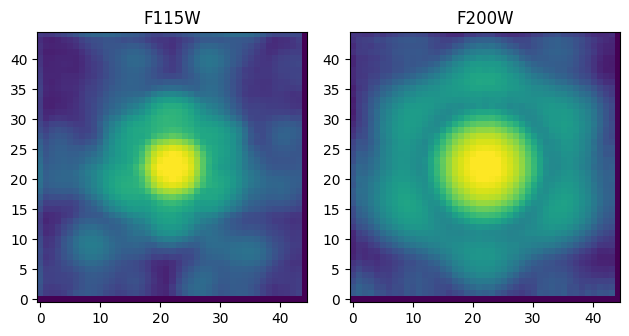

In [17]:
for det in dets_short: # for selected detector(s)
    for i, filt in enumerate(filts_short): # for selected filter(s)
        ax = plt.subplot(1, 2, i + 1) # create subplots
        norm_epsf = simple_norm(dict_psfs_epsf[det][filt]['epsf single'][i + 1].data, 'log', percent=99.) # normalize as before
        plt.title(filt) # add title
        ax.imshow(dict_psfs_epsf[det][filt]['epsf single'][i + 1].data, norm=norm_epsf) # plot
plt.tight_layout()

In [18]:
# We are now at the stage where we can perform PSF photometry on the images
# by default, we save the output catalogs and the residual images in a new dictionary
dict_phot = {} # make an empty dictionary

for det in dets_short: # for selected detector(s)
    dict_phot.setdefault(det, {}) # make a dictionary with the same dimensions, to match the number of detectors...
    for j, filt in enumerate(filts_short): # (for selected filter(s))
        dict_phot[det].setdefault(filt, {}) # as well as the number of filters

        dict_phot[det][filt]['residual images'] = {} # initialize keyword for data storage later
        dict_phot[det][filt]['output photometry tables'] = {} # initialize keyword for data storage later

        for i in np.arange(0, len(dict_images[det][filt]['images']), 1): # for each image
            dict_phot[det][filt]['residual images'][i + 1] = None # fill the newly-created keyword with 'None' for now
            dict_phot[det][filt]['output photometry tables'][i + 1] = None # fill the newly-created keyword with 'None' for now

In [19]:
# Next, we create our PSF photometry function
# the threshold below ('th') that we pass into our finding algorithm is very high, in order to speed up this notebook
# for meaningful data reduction, please modify the threshold accordingly
# here, we also choose to use the grid of WebbPSF PSF as our PSF model
# modify the 'psf' parameter to select other options (single WebbPSF PSF, single ePSF)
from astropy.modeling.fitting import LevMarLSQFitter
from photutils.psf import SourceGrouper, IterativePSFPhotometry, webbpsf_reader, GriddedPSFModel
from webbpsf.utils import to_griddedpsfmodel
import pandas as pd
from astropy.table import Table
import time
def psf_phot(det='NRCA1', filt='F070W', th=2000, psf='grid_webbpsf', save_residuals=False, save_output=False):
    bkgrms = MADStdBackgroundRMS() # class to calculate the background RMS in an array as using the median absolute deviation (MAD)
    mmm_bkg = MMMBackground() # class to calculate the background in an array using the DAOPHOT MMM algorithm
    fitter = LevMarLSQFitter() # use the Levenberg-Marquardt algorithm and least squares statistic to fit the sources

    im = fits.open(dict_images[det][filt]['images'][i]) # open the image
    data_sb = im[1].data # the data we're using
    imh = im[1].header # image header
    d = im[0].header['DETECTOR'] # from the header, read in the detector
    prim_dith_pos = im[0].header['PATT_NUM'] # from the header, read in the position number within the dither pattern
    prim_dith_num = im[0].header['NUMDTHPT'] # from the header, read in the total number of points in the dither pattern
    subpx_dith_pos = im[0].header['SUBPXNUM'] # from the header, read in the subpixel pattern number
    subpx_dith_num = im[0].header['SUBPXPNS'] # from the header, read in the total number of points in subpixel pattern
    
    data = data_sb / imh['PHOTMJSR'] # unit conversion
    units = imh['BUNIT'] # as before
    print(f"Conversion factor from {units} to DN/s for filter {filt}: {imh['PHOTMJSR']}")
    print("Applying conversion to the data")

    sigma_psf = dict_utils[filt]['psf fwhm'] # FWHM of the PSF
    print(f"FWHM for the filter {filt}: {sigma_psf}")

    std = bkgrms(data) # data background RMS
    bkg = mmm_bkg(data) # data background

    daofind = DAOStarFinder(threshold=th * std + bkg, fwhm=sigma_psf, roundhi=1.0, roundlo=-1.0, sharplo=0.30, sharphi=1.40)
    # the threshold is the absolute image value above which to select sources, where
    # roundhi is the upper bound on 'roundness' for object detection; roundlo is the lower bound
    # sharplo is the lower bound on 'sharpness' for object detection; sharphi is the upper bound

    grouper = SourceGrouper(5.0 * sigma_psf) # group stars into clusters based on an input minimum separation distance

    if psf == 'grid_webbpsf': # when using the grid of WebbPSFs for the PSF model,
        print("Using as PSF model WebbPSF PSFs grid")
        psf_model = dict_psfs_webbpsf[det][filt]['psf model grid'].copy() # make a copy of the grid
    if psf == 'single_webbpsf': # when using the single WebbPSF for the PSF model,
        print("Using as PSF model WebbPSF single PSF")
        psf_model = dict_psfs_webbpsf[det][filt]['psf model single'].copy() # make a copy of the single PSF
    if psf == 'single_epsf': # when using the single ePSF for the PSF model,
        print("Using as PSF model single ePSF")
        psf_model = dict_psfs_epsf[det][filt]['epsf single'][i + 1].copy() # make a copy of the ePSF
    print(f"Performing the photometry on image {i + 1} of filter {filt}, detector {det}")
            
    tic = time.perf_counter() # start timer

    data_sub = data - mmm_bkg(data) # background-subtracted data
    psf_shape = (11, 11) # fit shape, the rectangular shape around the center of the star that will be used to define the PSF-fitting data
    phot = IterativePSFPhotometry(psf_model, psf_shape, daofind, grouper=grouper, fitter=fitter, maxiters=2, aperture_radius=ap_radius[j])
    # using our PSF model, fit shape, star finder, grouper, fitter
    # along with aperture radius (the radius of the circular aperture used to estimate the initial flux of each source, defined in next cell)
    # and performing (only) two iterations, we iteratively perform PSF photometry...
    result = phot(data_sub) # ... on the background-subtracted data

    toc = time.perf_counter() # end the timer
    dtime = (toc - tic) # calculate duration
    print(f"Time needed to perform photometry on image {i + 1}: {dtime:.2f} sec")
    print(f"Number of sources detected in image {i + 1} for filter {filt}: {len(result)}")

    dict_phot[det][filt]['output photometry tables'][i + 1] = result # add our results to our dictionary
    residual_image = phot.make_residual_image(data_sub, psf_shape) # generate a residual image using the 'make_residual_image' method
    dict_phot[det][filt]['residual images'][i + 1] = residual_image # and add the residual image to our dictionary

    if save_residuals: # if we choose to save the residual images as .fits file
        hdu = fits.PrimaryHDU(residual_image) # construct a primary HDU from the residual image
        hdul = fits.HDUList([hdu]) # create an HDUList instance
        residual_outname = f'residual_{d}_{filt}_webbPSF_gridPSF_{prim_dith_pos}of{prim_dith_num}_{subpx_dith_pos}of{subpx_dith_num}.fits' 
        # specify the name we wish to give to the new file
        dir_output_phot = './' # put the new file in our current directory
        hdul.writeto(os.path.join(dir_output_phot, residual_outname)) # push the addition
        outname = f'phot_{d}_{filt}_webbPSF_gridPSF_level2_{prim_dith_pos}of{prim_dith_num}_{subpx_dith_pos}of{subpx_dith_num}.pkl'
        # specify the name that the pandas object would have
    if save_output: # save the output photometry Tables
        tab = result.to_pandas() # convert to pandas format
        tab.to_pickle(os.path.join(dir_output_phot, outname)) # make pickles pandas object

In [20]:
tic_tot = time.perf_counter() # start timer

ap_radius = [3.0, 3.0]  # the radius of the circular aperture used to estimate the initial flux of each source, must match the number of filters analyzed 

if glob.glob('./*residual*.fits'): # if we've already made residual files in this directory
    print("Deleting Residual images from directory")
    files = glob.glob('./residual*.fits') # select the existing residuals files
    for file in files: # for each existing file
        os.remove(file) # remove it
        
for det in dets_short: # for selected detector(s)
    for j, filt in enumerate(filts_short): # for selected filter(s)
        for i in np.arange(0, len(dict_images[det][filt]['images']), 1): # for each image
            psf_phot(det=det, filt=filt, th=100, psf='grid_webbpsf', save_residuals=True, save_output=True) 
            # run PSF photometry, using an exaggerated threshold of 2000, the grid of WebbPSFs, saving the residuals and output
toc_tot = time.perf_counter() # stop timer
number = len(filts_short) * len(dict_images[det][filt]['images']) # number of images to perform photoemtry on
dtime = (toc_tot - tic_tot) # elapsed time
print(f"Time elapsed to perform the photometry of the {number} images: {dtime:.2f} sec") 

Deleting Residual images from directory
Conversion factor from MJy/sr to DN/s for filter F115W: 3.821892261505127
Applying conversion to the data
FWHM for the filter F115W: 1.298
Using as PSF model WebbPSF PSFs grid
Performing the photometry on image 1 of filter F115W, detector NRCB1


Time needed to perform photometry on image 1: 125.09 sec
Number of sources detected in image 1 for filter F115W: 5704
Conversion factor from MJy/sr to DN/s for filter F115W: 3.821892261505127
Applying conversion to the data
FWHM for the filter F115W: 1.298
Using as PSF model WebbPSF PSFs grid
Performing the photometry on image 2 of filter F115W, detector NRCB1


Time needed to perform photometry on image 2: 137.61 sec
Number of sources detected in image 2 for filter F115W: 5654
Conversion factor from MJy/sr to DN/s for filter F115W: 3.821892261505127
Applying conversion to the data
FWHM for the filter F115W: 1.298
Using as PSF model WebbPSF PSFs grid
Performing the photometry on image 3 of filter F115W, detector NRCB1


Time needed to perform photometry on image 3: 141.60 sec
Number of sources detected in image 3 for filter F115W: 5717
Conversion factor from MJy/sr to DN/s for filter F115W: 3.821892261505127
Applying conversion to the data
FWHM for the filter F115W: 1.298
Using as PSF model WebbPSF PSFs grid
Performing the photometry on image 4 of filter F115W, detector NRCB1


Time needed to perform photometry on image 4: 158.81 sec
Number of sources detected in image 4 for filter F115W: 5685
Conversion factor from MJy/sr to DN/s for filter F200W: 2.564082860946655
Applying conversion to the data
FWHM for the filter F200W: 2.141
Using as PSF model WebbPSF PSFs grid
Performing the photometry on image 1 of filter F200W, detector NRCB1


Time needed to perform photometry on image 1: 190.15 sec
Number of sources detected in image 1 for filter F200W: 3770
Conversion factor from MJy/sr to DN/s for filter F200W: 2.564082860946655
Applying conversion to the data
FWHM for the filter F200W: 2.141
Using as PSF model WebbPSF PSFs grid
Performing the photometry on image 2 of filter F200W, detector NRCB1


Time needed to perform photometry on image 2: 175.49 sec
Number of sources detected in image 2 for filter F200W: 3746
Conversion factor from MJy/sr to DN/s for filter F200W: 2.564082860946655
Applying conversion to the data
FWHM for the filter F200W: 2.141
Using as PSF model WebbPSF PSFs grid
Performing the photometry on image 3 of filter F200W, detector NRCB1


Time needed to perform photometry on image 3: 132.61 sec
Number of sources detected in image 3 for filter F200W: 3783
Conversion factor from MJy/sr to DN/s for filter F200W: 2.564082860946655
Applying conversion to the data
FWHM for the filter F200W: 2.141
Using as PSF model WebbPSF PSFs grid
Performing the photometry on image 4 of filter F200W, detector NRCB1


Time needed to perform photometry on image 4: 114.85 sec
Number of sources detected in image 4 for filter F200W: 3787
Time elapsed to perform the photometry of the 8 images: 1260.21 sec


In [21]:
for det in dets_short: # for each detector
    for i, filt in enumerate(filts_short): # for each filter
        dict_phot[det][filt]['output photometry tables'][1] # the output photometry table

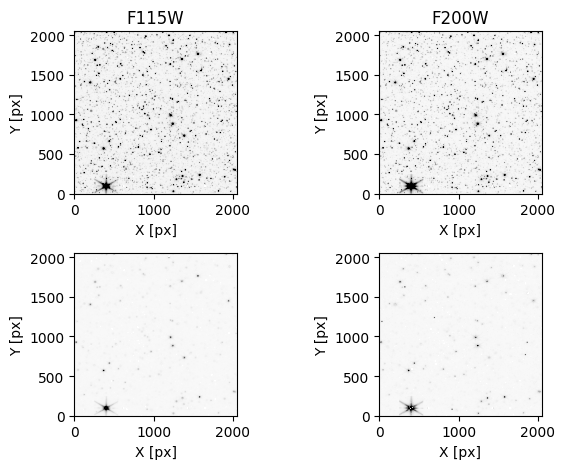

In [22]:
# As a comparison, we can display the subtracted image

for det in dets_short: # for selected detector(s)
    for i, filt in enumerate(filts_short): # for selected filter(s)
        image = fits.open(dict_images[det][filt]['images'][0]) # open the image
        data_sb = image[1].data # grab the data
        ax = plt.subplot(2, len(filts_short), i + 1) # setup the subplot
        plt.xlabel("X [px]") # label the x-axis
        plt.ylabel("Y [px]") # label the y-axis
        plt.title(filt) # title it
        norm = simple_norm(data_sb, 'sqrt', percent=99.) # normalize as before
        ax.imshow(data_sb, norm=norm, cmap='Greys') # plot
for det in dets_short: # for selected detector(s)
    for i, filt in enumerate(filts_short): # for selected filter(s)
        res = dict_phot[det][filt]['residual images'][1] # open the residual image
        ax = plt.subplot(2, len(filts_short), i + 3) # setup the subplot
        plt.xlabel("X [px]") # label the x-axis
        plt.ylabel("Y [px]") # label the y-axis
        norm = simple_norm(data_sb, 'sqrt', percent=99.) # normalize as before
        ax.imshow(res, norm=norm, cmap='Greys') # plot
plt.tight_layout()

In [23]:
# Data analysis
# if you haven't, run psf_phot with save_outputs = True
from astropy.table import QTable
cat_dir = './' # in the current directory
phots_pkl_f115w = sorted(glob.glob(os.path.join(cat_dir, '*F115W*gridPSF*.pkl'))) # find the photometry file for the filter of interest
phots_pkl_f200w = sorted(glob.glob(os.path.join(cat_dir, '*F200W*gridPSF*.pkl'))) # find the photometry file for the filter of interest
results_f115w = [] # somewehere to store the results
results_f200w = [] # somewehere to store the results
for phot_pkl_f115w, phot_pkl_f200w in zip(phots_pkl_f115w, phots_pkl_f200w):
    ph_f115w = pd.read_pickle(phot_pkl_f115w) # read the file
    ph_f200w = pd.read_pickle(phot_pkl_f200w) # read the file
    result_f115w = QTable.from_pandas(ph_f115w) # extract the data
    result_f200w = QTable.from_pandas(ph_f200w) # extract the data
    results_f115w.append(result_f115w) # add the data to results
    results_f200w.append(result_f200w) # add the data to results

In [24]:
# Now, we transform the images to DataModel so that we can assign the WCS coordinate and then cross-match the images
from jwst.datamodels import ImageModel
images_f115w = [] # empty list
images_f200w = [] # empty list
for i in np.arange(0, len(dict_images['NRCB1']['F115W']['images']), 1): # for each image
    image_f115w = ImageModel(dict_images['NRCB1']['F115W']['images'][i]) # turn it into an ImageModel object
    images_f115w.append(image_f115w) # and add it to the list
for i in np.arange(0, len(dict_images['NRCB1']['F200W']['images']), 1): # for each image
    image_f200w = ImageModel(dict_images['NRCB1']['F200W']['images'][i]) # turn it into an ImageModel object
    images_f200w.append(image_f200w) # and add it to the list

In [25]:
# We proceed to cross-matching the catalogs
# We consider stars from the two filters to be associated if the distance between the matches is < 0.5 px
from astropy.coordinates import SkyCoord
results_clean_f115w = []
results_clean_f200w = []

for i in np.arange(0, len(images_f115w), 1): # for the F115W images
    mask_f115w = ((results_f115w[i]['x_fit'] > 0) & (results_f115w[i]['x_fit'] < 2048) &
                  (results_f115w[i]['y_fit'] > 0) & (results_f115w[i]['y_fit'] < 2048) &
                  (results_f115w[i]['flux_fit'] > 0))
    # mask to exclude fits that fall off of the image or did not detect a flux
    result_clean_f115w = results_f115w[i][mask_f115w] # add the masked data to results
    ra_f115w, dec_f115w = images_f115w[i].meta.wcs(result_clean_f115w['x_fit'], result_clean_f115w['y_fit'])
    # access the WCS as an attribute of the meta object (the coordinates are assigned during the 'assign_wcs' step in the JWST pipeline)
    radec_f115w = SkyCoord(ra_f115w, dec_f115w, unit='deg') # make SkyCoord object with physical (degrees) coordinates
    result_clean_f115w['radec'] = radec_f115w # store the RA and DEC info
    results_clean_f115w.append(result_clean_f115w) # and add it to our bigger list

    mask_f200w = ((results_f200w[i]['x_fit'] > 0) & (results_f200w[i]['x_fit'] < 2048) & # repeat same as above but for other filter
                  (results_f200w[i]['y_fit'] > 0) & (results_f200w[i]['y_fit'] < 2048) &
                  (results_f200w[i]['flux_fit'] > 0))
    result_clean_f200w = results_f200w[i][mask_f200w]
    ra_f200w, dec_f200w = images_f200w[i].meta.wcs(result_clean_f200w['x_fit'], result_clean_f200w['y_fit'])
    radec_f200w = SkyCoord(ra_f200w, dec_f200w, unit='deg')
    result_clean_f200w['radec'] = radec_f200w
    results_clean_f200w.append(result_clean_f200w)

In [26]:
# for NIRCam detectors, in the short wavelength, the pixel scale is 0.031 arcseconds per pixel
# so, to have our maximum separation be 0.5 px, 0.031/2 = 0.015 arcsecs
from astropy import units as u
from astropy.coordinates import match_coordinates_sky
max_sep = 0.015 * u.arcsec # maximum separation
matches_phot_single = [] # empty list
filt1 = 'F115W' # specify our filters
filt2 = 'F200W'
for res1, res2 in zip(results_clean_f115w, results_clean_f200w): # for each result (for both filters)
    idx, d2d, _ = match_coordinates_sky(res1['radec'], res2['radec']) # find the nearest on-sky matches
    # idx: index array to get the matched points
    # d2d: sep2d, the on-sky separation between the closest match for each match coordinate
    # _: dist3d, the 3D distance between the closest match for each match coordinate
    sep_constraint = d2d < max_sep # set the minimum separation distance to be considered a matching source

    match_phot_single = Table() # create Table to store matches
    
    x_init_f115w = res1['x_init'][sep_constraint] # grab the column of initial x-positions, filtering for those that meet the separation constraint
    y_init_f115w = res1['y_init'][sep_constraint] # repeat for inital y-positions
    x_fit_f115w = res1['x_fit'][sep_constraint] # and for the fit x-positions
    y_fit_f115w = res1['y_fit'][sep_constraint] # as well as the fit y-positions
    radec_f115w = res1['radec'][sep_constraint] # and finally for the RA and DEC
    mag_f115w = (-2.5 * np.log10(res1['flux_fit']))[sep_constraint] # obtain the Vega magnitude from flux densities in MJy/sr
    # for more information, visit https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-performance/nircam-absolute-flux-calibration-and-zeropoints
    emag_f115w = (1.086 * (res1['flux_err'] / res1['flux_fit']))[sep_constraint] # error in the magnitude, given uncertainty in the fitted flux (take derivative)

    x_init_f200w = res2['x_init'][idx[sep_constraint]] # repeat with other filter, using the index array to match the points
    y_init_f200w = res2['y_init'][idx[sep_constraint]] # ^
    x_fit_f200w = res2['x_fit'][idx[sep_constraint]] # ^
    y_fit_f200w = res2['y_fit'][idx[sep_constraint]] # ^
    radec_f200w = res2['radec'][idx][sep_constraint] # ^
    mag_f200w = (-2.5 * np.log10(res2['flux_fit']))[idx[sep_constraint]] # ^
    emag_f200w = (1.086 * (res2['flux_err'] / res2['flux_fit']))[idx[sep_constraint]] # ^

    match_phot_single['x_init_' + filt1] = x_init_f115w # now add the data of our matches to the Table
    match_phot_single['y_init_' + filt1] = y_init_f115w # ^
    match_phot_single['x_fit_' + filt1] = x_fit_f115w # ^
    match_phot_single['y_fit_' + filt1] = y_fit_f115w # ^
    match_phot_single['radec_' + filt1] = radec_f115w # ^
    match_phot_single['mag_' + filt1] = mag_f115w # ^
    match_phot_single['emag_' + filt1] = emag_f115w # ^
    match_phot_single['x_init_' + filt2] = x_init_f200w # ^
    match_phot_single['y_init_' + filt2] = y_init_f200w # ^
    match_phot_single['x_fit_' + filt2] = x_fit_f200w # ^
    match_phot_single['y_fit_' + filt2] = y_fit_f200w # ^
    match_phot_single['radec_' + filt2] = radec_f200w # ^
    match_phot_single['mag_' + filt2] = mag_f200w # ^
    match_phot_single['emag_' + filt2] = emag_f200w # ^

    matches_phot_single.append(match_phot_single) # and add it to our big list

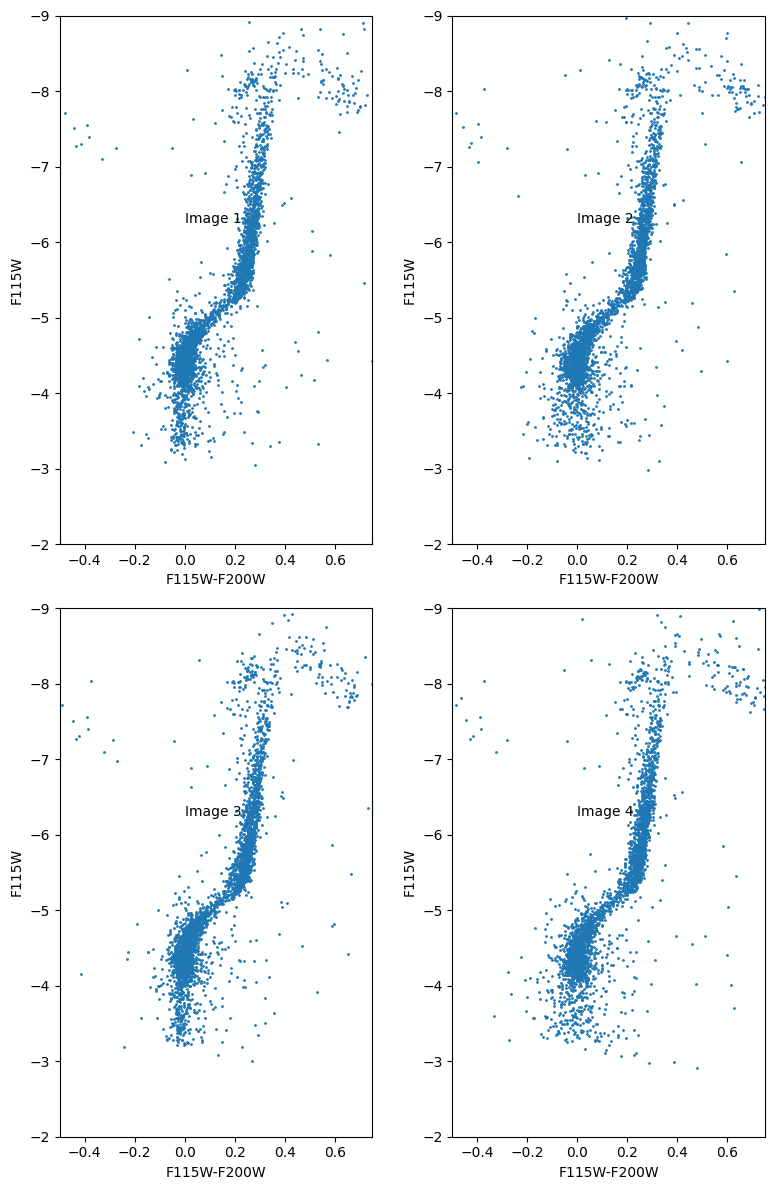

In [41]:
# We can now plot the color-magnitude diagrams (with instrumental magnitudes) of our images
plt.figure(figsize=(8, 12))
for i in np.arange(0, len(matches_phot_single), 1): # for each of our matches
    ax = plt.subplot(2, 2, i + 1) # define the subplot
    j = str(i + 1) # string to label our image number with
    # optionally, define x- and y-limits.  uncomment below and fill in values
    xlim_l = -0.5 # define lower x-limit
    xlim_u = 0.75 # define upper x-limit
    ylim_l = -2 # define lower y-limit
    ylim_u = -9 # define upper y-limit
    ax.set_xlim(xlim_l, xlim_u) # and implement these limits
    ax.set_ylim(ylim_l, ylim_u) # ^
    
    f115w_single = matches_phot_single[i]['mag_' + filt1] # grab the magnitude data for each filter
    f200w_single = matches_phot_single[i]['mag_' + filt2] # ^

    ax.scatter(f115w_single - f200w_single, f115w_single, s=1) # plot the difference in magnitude for the filters against the magnitudes of one filter
    # 's' sets the size of the marker
    ax.set_xlabel(filt1 + '-' + filt2) # label the x-axis
    ax.set_ylabel(filt1) # label the y-axis
    ax.text(0, -6.25, f"Image {j}") # label each subplot with its image number
plt.tight_layout()

In [28]:
# To go from 4 images/catalogs to one to obtain a final color-magnitude diagram, we need to cross-match all the catalogs for each filter
# and then cross-match the derived final catalogs.  We impose the conservative condition that a star must be found in all 4 catalogs to be kept
# This following function is not particularly eloquent, but it does the job
def crossmatch_filter(table=None): # function to perform the cross-matching
    num = 0 # catalog 1 is number 0
    num_cat = np.char.mod('%d', np.arange(1, len(table) + 1, 1)) # string array of catalog numbers (1,2,3,4)
    idx_12, d2d_12, _ = match_coordinates_sky(table[num]['radec'], table[num + 1]['radec']) # find the nearest on-sky matches for the first two catalogs
    sep_constraint_12 = d2d_12 < max_sep # separation constraint for the first two catalogs
    matches_12 = Table() # create Table to hold matches of first two catalogs
    # now, starting with the zeroth position catalog number,
    matches_12['radec_' + num_cat[num]] = table[num]['radec'][sep_constraint_12] # grab the RA and DEC info, imposing the separation constraint
    matches_12['mag_' + num_cat[num]] = (-2.5 * np.log10(table[num]['flux_fit']))[sep_constraint_12] # magnitude conversion
    matches_12['emag_' + num_cat[num]] = (1.086 * (table[num]['flux_err'] / table[num]['flux_fit']))[sep_constraint_12] # error in magnitude
    # now repeat for the second catalog, using the index array to match
    matches_12['radec_' + num_cat[num + 1]] = table[num + 1]['radec'][idx_12[sep_constraint_12]] # ^
    matches_12['mag_' + num_cat[num + 1]] = (-2.5 * np.log10(table[num + 1]['flux_fit']))[idx_12[sep_constraint_12]] # ^
    matches_12['emag_' + num_cat[num + 1]] = (1.086 * (table[num + 1]['flux_err'] / table[num + 1]['flux_fit']))[idx_12[sep_constraint_12]] # ^

    idx_123, d2d_123, _ = match_coordinates_sky(matches_12['radec_' + num_cat[num]], table[num + 2]['radec']) # we add in the third catalog
    sep_constraint_123 = d2d_123 < max_sep # and define our new separation constraint
    matches_123 = Table() # and create a new Table

    matches_123['radec_' + num_cat[num]] = matches_12['radec_' + num_cat[num]][sep_constraint_123] 
    # pull our previously-found matches through the new separation constraint
    matches_123['mag_' + num_cat[num]] = matches_12['mag_' + num_cat[num]][sep_constraint_123] # ^
    matches_123['emag_' + num_cat[num]] = matches_12['emag_' + num_cat[num]][sep_constraint_123] # ^
    matches_123['radec_' + num_cat[num + 1]] = matches_12['radec_' + num_cat[num + 1]][sep_constraint_123] # ^
    matches_123['mag_' + num_cat[num + 1]] = matches_12['mag_' + num_cat[num + 1]][sep_constraint_123] # ^
    matches_123['emag_' + num_cat[num + 1]] = matches_12['emag_' + num_cat[num + 1]][sep_constraint_123] # ^
    matches_123['radec_' + num_cat[num + 2]] = table[num + 2]['radec'][idx_123[sep_constraint_123]] # and then add our new matches
    matches_123['mag_' + num_cat[num + 2]] = (-2.5 * np.log10(table[num + 2]['flux_fit']))[idx_123[sep_constraint_123]] # ^
    matches_123['emag_' + num_cat[num + 2]] = (1.086 * (table[num + 2]['flux_err'] / table[num + 2]['flux_fit']))[idx_123[sep_constraint_123]] # ^

    idx_1234, d2d_1234, _ = match_coordinates_sky(matches_123['radec_' + num_cat[num]], table[num + 3]['radec']) # add in the fourth catalog
    sep_constraint_1234 = d2d_1234 < max_sep # with new separation constraint
    matches_1234 = Table() # and new Table

    matches_1234['radec_' + num_cat[num]] = matches_123['radec_' + num_cat[num]][sep_constraint_1234]
    # pull our previously-found matches through the new separation constraint
    matches_1234['mag_' + num_cat[num]] = matches_123['mag_' + num_cat[num]][sep_constraint_1234] # ^
    matches_1234['emag_' + num_cat[num]] = matches_123['emag_' + num_cat[num]][sep_constraint_1234] # ^
    matches_1234['radec_' + num_cat[num + 1]] = matches_123['radec_' + num_cat[num + 1]][sep_constraint_1234] # ^
    matches_1234['mag_' + num_cat[num + 1]] = matches_123['mag_' + num_cat[num + 1]][sep_constraint_1234] # ^
    matches_1234['emag_' + num_cat[num + 1]] = matches_123['emag_' + num_cat[num + 1]][sep_constraint_1234] # ^
    matches_1234['radec_' + num_cat[num + 2]] = matches_123['radec_' + num_cat[num + 2]][sep_constraint_1234] # ^
    matches_1234['mag_' + num_cat[num + 2]] = matches_123['mag_' + num_cat[num + 2]][sep_constraint_1234] # ^
    matches_1234['emag_' + num_cat[num + 2]] = matches_123['emag_' + num_cat[num + 2]][sep_constraint_1234] # ^
    matches_1234['radec_' + num_cat[num + 3]] = table[num + 3]['radec'][idx_1234[sep_constraint_1234]] # and then add our new matches
    matches_1234['mag_' + num_cat[num + 3]] = (-2.5 * np.log10(table[num + 3]['flux_fit']))[idx_1234[sep_constraint_1234]] # ^
    matches_1234['emag_' + num_cat[num + 3]] = (1.086 * (table[num + 3]['flux_err'] / table[num + 3]['flux_fit']))[idx_1234[sep_constraint_1234]] # ^

    matches_1234

    return matches_1234

In [29]:
matches_f115w = crossmatch_filter(table=results_clean_f115w) # cross-match all the catalogs for the F115W filter
matches_f200w = crossmatch_filter(table=results_clean_f200w) # cross-match all the catalogs for the F200W filter

In [30]:
# To get our final catalog, we assume that the magnitude is the mean of the 4 measures and the error on the magnitude is its standard deviation
# since we need to perform arithmatic operations on a table, we employ the help of pandas datafram
df_f115w = matches_f115w.to_pandas() # convert to PD
df_f200w = matches_f200w.to_pandas() # convert to PD

df_f115w['RA_' + filt1] = df_f115w[['radec_1.ra', 'radec_2.ra', 'radec_3.ra', 'radec_4.ra']].mean(axis=1) # find the mean RA
df_f115w['e_RA_' + filt1] = df_f115w[['radec_1.ra', 'radec_2.ra', 'radec_3.ra', 'radec_4.ra']].std(axis=1) # find the mean error in RA
df_f115w['Dec_' + filt1] = df_f115w[['radec_1.dec', 'radec_2.dec', 'radec_3.dec', 'radec_4.dec']].mean(axis=1) # find the mean DEC
df_f115w['e_Dec_' + filt1] = df_f115w[['radec_1.dec', 'radec_2.dec', 'radec_3.dec', 'radec_4.dec']].std(axis=1) # find the mean error in RA
df_f115w[filt1 + '_inst'] = df_f115w[['mag_1', 'mag_2', 'mag_3', 'mag_4']].mean(axis=1) # find the mean magnitude
df_f115w['e' + filt1 + '_inst'] = df_f115w[['mag_1', 'mag_2', 'mag_3', 'mag_4']].std(axis=1) # find the mean error in magnitude

df_f200w['RA_' + filt2] = df_f200w[['radec_1.ra', 'radec_2.ra', 'radec_3.ra', 'radec_4.ra']].mean(axis=1) # repeat for other filter
df_f200w['e_RA_' + filt2] = df_f200w[['radec_1.ra', 'radec_2.ra', 'radec_3.ra', 'radec_4.ra']].std(axis=1) # ^
df_f200w['Dec_' + filt2] = df_f200w[['radec_1.dec', 'radec_2.dec', 'radec_3.dec', 'radec_4.dec']].mean(axis=1) # ^
df_f200w['e_Dec_' + filt2] = df_f200w[['radec_1.dec', 'radec_2.dec', 'radec_3.dec', 'radec_4.dec']].std(axis=1) # ^
df_f200w[filt2 + '_inst'] = df_f200w[['mag_1', 'mag_2', 'mag_3', 'mag_4']].mean(axis=1) # ^
df_f200w['e' + filt2 + '_inst'] = df_f200w[['mag_1', 'mag_2', 'mag_3', 'mag_4']].std(axis=1) # ^

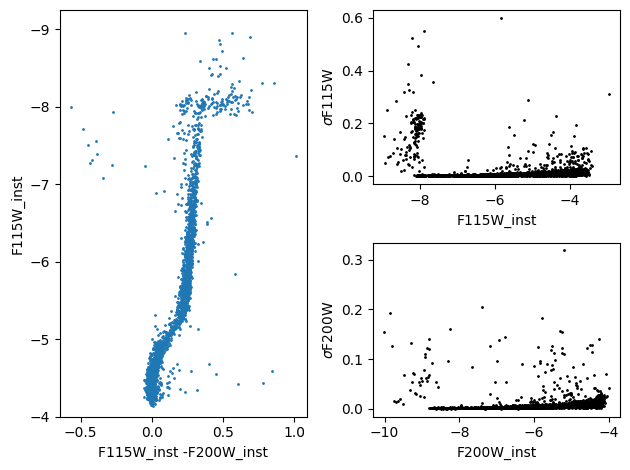

In [43]:
# The resulting color-magnitude diagram, still with instrumental magnitudes is as follows:
ax1 = plt.subplot(1, 2, 1) # define subplot
ax1.set_xlabel(filt1 + '_inst -' + filt2 + '_inst') # label the x-axis
ax1.set_ylabel(filt1 + '_inst') # label the y-axis
# optional: add x- and y-limits
# xlim_l =  # define lower x-limit
# xlim_u =  # define upper x-limit
ylim_l = -4 # define lower y-limit
ylim_u = -9.25 # define upper y-limit
# ax1set_xlim(xlim_l, xlim_u) # and implement these limits
ax1.set_ylim(ylim_l, ylim_u) # ^

radec_f115w_inst = SkyCoord(df_f115w['RA_' + filt1], df_f115w['Dec_' + filt1], unit='deg') # grab our mean RAs, DECs for each filter
radec_f200w_inst = SkyCoord(df_f200w['RA_' + filt2], df_f200w['Dec_' + filt2], unit='deg') # ^

idx_inst, d2d_inst, _ = match_coordinates_sky(radec_f115w_inst, radec_f200w_inst) # find the nearest on-sky matches
sep_constraint_inst = d2d_inst < max_sep # define our separation constraint

f115w_inst = np.array(df_f115w[filt1 + '_inst'][sep_constraint_inst]) # turn our magnitude PD into an array, filtering using the separation constraint
ef115w_inst = np.array(df_f115w['e' + filt1 + '_inst'][sep_constraint_inst]) # repeat for error in magnitude
radec_f115w = radec_f115w_inst[sep_constraint_inst] # and positions

f200w_inst = np.array(df_f200w[filt2 + '_inst'][idx_inst[sep_constraint_inst]]) # repeat for other filter
ef200w_inst = np.array(df_f200w['e' + filt2 + '_inst'][idx_inst[sep_constraint_inst]]) # ^
radec_f200w = radec_f200w_inst[idx_inst[sep_constraint_inst]] # ^

ax1.scatter(f115w_inst - f200w_inst, f115w_inst, s=1) # plot the difference in magnitude against the F115W magnitudes

ax2 = plt.subplot(2, 2, 2) # now we create a subplot for the magnitude errors in F115W
ax2.set_xlabel(filt1 + '_inst')
ax2.set_ylabel(r'$\sigma$' + filt1)
# optional: add x- and y-limits
# xlim_l =  # define lower x-limit
# xlim_u =  # define upper x-limit
# ylim_l = # define lower y-limit
# ylim_u = # define upper y-limit
# ax2.set_xlim(xlim_l, xlim_u) # and implement these limits
# ax2.set_ylim(ylim_l, ylim_u) # ^
ax2.scatter(df_f115w[filt1 + '_inst'], df_f115w['e' + filt1 + '_inst'], s=1, color='k') # plot the error in magnitudes against the magnitudes

ax3 = plt.subplot(2, 2, 4) # repeat for F200W
ax3.set_xlabel(filt2 + '_inst') # ^
ax3.set_ylabel(r'$\sigma$' + filt2) # ^
# ax3.set_xlim(xlim_l, xlim_u)
# ax3.set_ylim(ylim_l, ylim_u)
ax3.scatter(df_f200w[filt2 + '_inst'], df_f200w['e' + filt2 + '_inst'], s=1, color='k') # ^

plt.tight_layout()

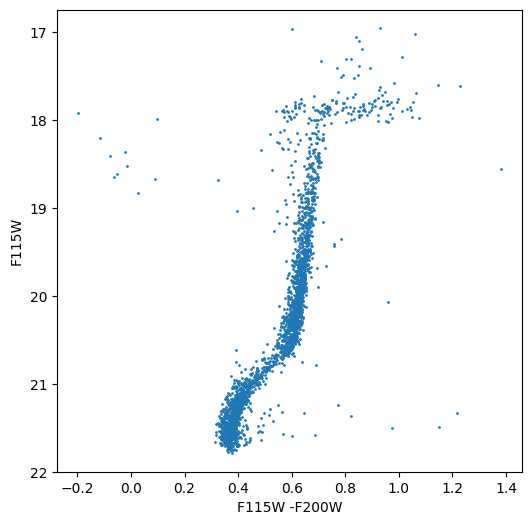

In [48]:
# To obtain the final calibrated color-magnitude diagram, we need to use the photometric zeropoints
# The zeropoints for each filter-detector combination can be found in the pmap linked on
# https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-performance/nircam-absolute-flux-calibration-and-zeropoints#NIRCamAbsoluteFluxCalibrationandZeropoints-NRC_zeropoints
# Here, we are using "jwst_1126.pmap", delivered September 14, 2023
# We find the calibrated magnitude m = m_zp + m_inst0
# Since we are using detector NRCB1, the zp_vega value for F115W is 25.92, and 25.55 for F200W
# (https://jwst-docs.stsci.edu/files/182256933/224166043/1/1695068757137/NRC_ZPs_1126pmap.txt)
plt.figure(figsize=(6, 6))
plt.xlabel(filt1 + ' -' + filt2) # label the x-axis
plt.ylabel(filt1) # label the y-axis
f115w = 25.92 + f115w_inst
f200w = 25.55 + f200w_inst
ylim_l = 22 # define lower y-limit
ylim_u = 16.75 # define upper y-limit
plt.ylim(ylim_l, ylim_u)
plt.scatter(f115w - f200w, f115w, s=1) # plot the difference in magnitude against the F115W magnitudes